[View in Colaboratory](https://colab.research.google.com/github/aseria/mlcc/blob/test/sparsity_and_l1_regularization.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 희소성과 L1 정규화

 **학습 목표:**
  * 모델의 크기를 계산한다
  * L1 정규화를 적용하여 희소성을 높임으로써 모델의 크기를 축소한다

 복잡도를 낮추는 방법 중 하나는 가중치를 정확히 0으로 유도하는 정규화 함수를 사용하는 것입니다. 회귀와 같은 선형 모델에서 가중치 0은 해당 특성을 전혀 사용하지 않는 것과 동일합니다. 이렇게 하면 과적합이 방지될 뿐 아니라 결과 모델의 효율성이 올라갑니다.

L1 정규화는 희소성을 높이는 좋은 방법입니다.



 ## 설정

아래 셀을 실행하여 데이터를 로드하고 특성 정의를 만드세요.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # medianHouseValue is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2635.6,538.1,1424.1,499.7,3.9,2.0
std,2.1,2.0,12.6,2165.6,419.8,1158.0,383.5,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1463.8,298.0,791.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2123.0,433.0,1166.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3148.0,647.0,1705.0,602.0,4.7,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.3,2662.9,542.5,1442.7,504.9,3.9,2.0
std,2.1,2.0,12.5,2214.0,425.5,1123.0,387.1,1.9,1.2
min,32.6,-124.3,2.0,24.0,3.0,9.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,293.8,787.8,279.0,2.6,1.5
50%,34.2,-118.5,28.0,2140.0,437.0,1170.0,410.0,3.6,1.9
75%,37.7,-118.0,36.0,3158.0,654.0,1761.2,611.0,4.8,2.3
max,42.0,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in range(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """

  bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
  bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
  bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
  bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
  bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
  bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
  bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

  long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

In [7]:
construct_feature_columns()

{_CrossedColumn(keys=(_BucketizedColumn(source_column=_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(-122.78, -122.52000000000001, -122.44, -122.38, -122.29000000000002, -122.25, -122.19, -122.11803921568628, -122.04999999999998, -122.0, -121.94, -121.86, -121.76999999999998, -121.55, -121.42, -121.31, -121.22, -120.99, -120.65, -120.2, -119.79, -119.59960784313725, -119.2, -118.96000000000001, -118.56, -118.46, -118.42, -118.38, -118.35, -118.32, -118.29, -118.26, -118.22, -118.19, -118.15, -118.12, -118.08, -118.02, -117.97, -117.93, -117.88, -117.79, -117.68, -117.4892156862745, -117.32, -117.24, -117.16, -117.1, -117.04, -116.89)), _BucketizedColumn(source_column=_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(32.73, 32.79, 32.94823529411765, 33.21, 33.62, 33.7, 33.75, 33.79, 33.83, 33.86, 33.89, 33.92, 33.94, 33.97, 33.99, 34.02, 34.04, 34.05, 34.07

 ## 모델 크기 계산

모델 크기를 계산하려면 단순히 0이 아닌 매개변수의 개수를 세면 됩니다. 아래는 이 작업을 위한 도우미 함수입니다. 이 함수에서는 Estimators API를 긴밀하게 활용하지만 그 원리를 이해할 필요는 없습니다.

In [0]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

 ## 모델 크기 축소

팀에서 *SmartRing*에 고도로 정확한 로지스틱 회귀 모델을 구축하려고 합니다. 이 제품은 인근 지역의 인구통계(`median_income`, `avg_rooms`, `households` 등)를 감지하여 거주 비용이 높은지 여부를 알려주는 스마트 반지입니다.

SmartRing은 크기가 작으므로 엔지니어링팀은 **매개변수가 600개 이하**인 모델까지만 처리가 가능하다고 판단했습니다. 한편, 제품관리팀은 홀드아웃 테스트 세트에 대한 **LogLoss가 0.35 미만**이어야 모델을 출시할 수 있다고 판단했습니다.

여기에서 L1 정규화라는 비밀 무기를 구사하여 크기와 정확성 조건을 모두 만족하도록 모델을 조정할 수 있을까요?

 ### 작업 1: 효과적인 정규화 계수 구하기

**모델 크기 600 미만, 검증세트에 대한 로그 손실 0.36 미만이라는 두 조건을 모두 만족하는 L1 정규화 강도 매개변수를 구하세요.**

다음 코드를 출발점으로 삼을 수 있습니다. 모델에 정규화를 적용하는 방법은 다양합니다. 여기에서는 L1 정규화를 사용할 때 표준 경사하강법보다 뛰어난 결과를 산출하는 `FtrlOptimizer`를 사용합니다.

또한 모델은 전체 데이터 세트를 학습하므로 평소보다 느리게 실행됩니다.

In [0]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on validation data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on validation data):
  period 00 : 0.32
  period 01 : 0.29
  period 02 : 0.27
  period 03 : 0.26
  period 04 : 0.26
  period 05 : 0.25
  period 06 : 0.25
Model training finished.
Model size: 791


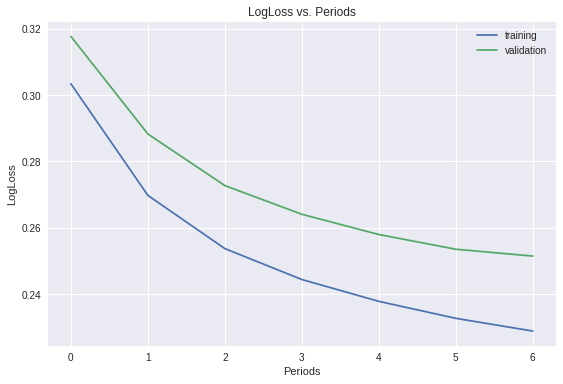

In [12]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.0,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (on validation data):
  period 00 : 0.32
  period 01 : 0.29
  period 02 : 0.28
  period 03 : 0.27
  period 04 : 0.26
  period 05 : 0.26
  period 06 : 0.25
Model training finished.
Model size: 760


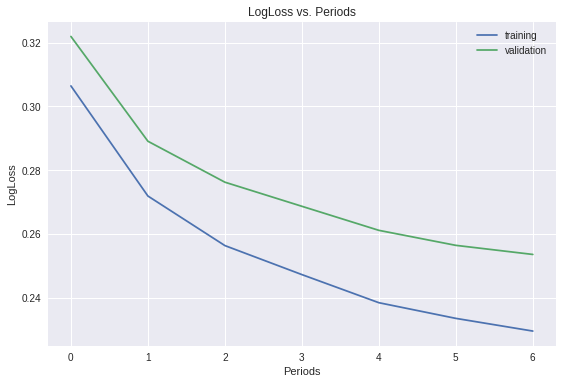

In [11]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.1, # 0.0 -> 0.1
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (on validation data):
  period 00 : 0.33
  period 01 : 0.29
  period 02 : 0.28
  period 03 : 0.27
  period 04 : 0.26
  period 05 : 0.26
  period 06 : 0.26
Model training finished.
Model size: 693


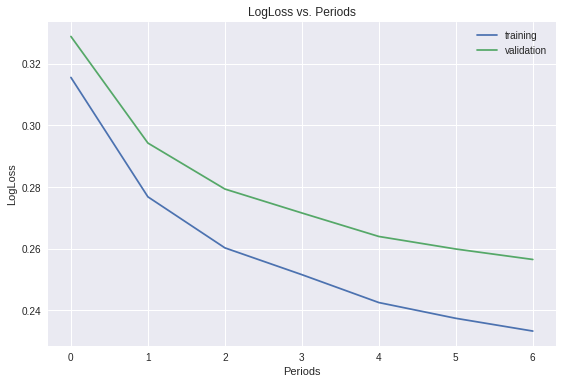

In [14]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.3, # 0.0 -> 0.1
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

Training model...
LogLoss (on validation data):
  period 00 : 0.34
  period 01 : 0.30
  period 02 : 0.29
  period 03 : 0.28
  period 04 : 0.27
  period 05 : 0.26
  period 06 : 0.26
Model training finished.
Model size: 534


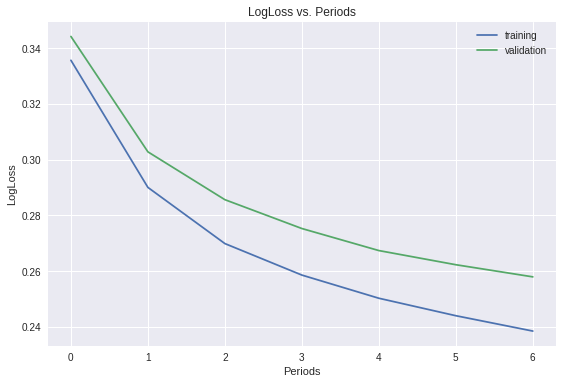

In [15]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=1, # 0.0 -> 0.1
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))

 ### 해결 방법

가능한 해결 방법을 보려면 아래를 클릭하세요.

 정규화 강도 0.1이면 충분합니다. 여기에서 절충이 필요하다는 점에 유의하세요. 정규화 강도를 높이면 모델이 작아지지만 분류 손실에 영향을 줄 수 있습니다.

Training model...
LogLoss (on validation data):
  period 00 : 0.33
  period 01 : 0.29
  period 02 : 0.28
  period 03 : 0.27
  period 04 : 0.26
  period 05 : 0.26
  period 06 : 0.25
Model training finished.
Model size: 757


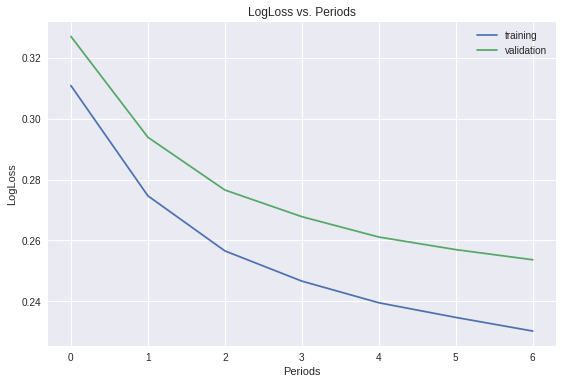

In [13]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    regularization_strength=0.1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Model size:", model_size(linear_classifier))